In [8]:
!pip install ripser

In [9]:
# Package Import
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering, MeanShift, estimate_bandwidth, DBSCAN, OPTICS, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, rand_score
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
import networkx as nx
from sklearn.metrics import pairwise_distances
from itertools import combinations

In [10]:
#generate Linked Tori dataset

pi = np.pi

u_1 = np.random.uniform(0, 2*pi, 1000)
v_1 = np.random.uniform(0, 2*pi, 1000)
x_1 = (5 + 2 * np.cos(v_1)) * np.cos(u_1)
y_1 = (5 + 2 * np.cos(v_1)) * np.sin(u_1)
z_1 = 2 * np.sin(v_1)
D_1 = np.zeros((1000, 4))
for i in range(0, 1000):
    D_1[i][0] = x_1[i]
    D_1[i][1] = y_1[i]
    D_1[i][2] = z_1[i]
    D_1[i][3] = 0

u_2 = np.random.uniform(0, 2*pi, 1000)
v_2 = np.random.uniform(0, 2*pi, 1000)
x_2 = (5 + 2 * np.cos(v_2)) * np.cos(u_2) + 5
y_2 = 2 * np.sin(v_2)
z_2 = (5 + 2 * np.cos(v_2)) * np.sin(u_2)
D_2 = np.zeros((1000, 4))
for i in range(0, 1000):
    D_2[i][0] = x_2[i]
    D_2[i][1] = y_2[i]
    D_2[i][2] = z_2[i]
    D_2[i][3] = 1

D = np.concatenate((D_1, D_2), axis=0)
label = D[:,3]
data = D[:,0:3]

np.random.seed(42)
x = data[:,0]
y = data[:,1]
z = data[:,2]

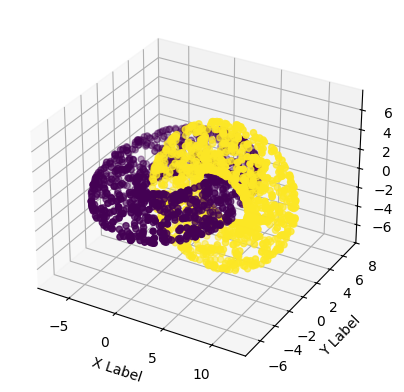

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z,c=label, cmap='viridis', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# ax.set_axis_off()

plt.show()

#BFTC

In [14]:
from ripser import ripser

num_clust = int(input("Number of Clusters:"))

import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def extract_betti(PD, scale_seq):
    b = np.zeros(len(scale_seq))
    for k in range(len(scale_seq)):
        b[k] = np.sum((scale_seq[k] >= PD[:, 0]) & (scale_seq[k] < PD[:, 1]))
    return b

def knn(data, nKNN):
    knn = NearestNeighbors(n_neighbors=nKNN).fit(data)
    dists, ind = knn.kneighbors(data)

    weights = 1 / (dists + 1e-5)

    return ind, weights

def bftc(data, nKNN, filt_len=100):
    N = data.shape[0]

    ind, weights = knn(data, nKNN)
    maxscale = np.max(1 / weights[:, -1])

    scale_seq = np.linspace(0, maxscale, filt_len)

    betti_0 = np.zeros((N, filt_len))
    betti_1 = np.zeros((N, filt_len))
    betti_2 = np.zeros((N, filt_len))

    for i in range(N):

        neighborhood = data[ind[i,]]

        rips = ripser(neighborhood, maxdim=2)
        PD_0 = rips['dgms'][0]
        PD_1 = rips['dgms'][1]
        PD_2 = rips['dgms'][2]

        PD_0[PD_0[:, 1] == np.inf, 1] = maxscale
        PD_1[PD_1[:, 1] == np.inf, 1] = maxscale
        PD_2[PD_2[:, 1] == np.inf, 1] = maxscale

        betti_0[i, :] = extract_betti(PD_0, scale_seq)
        betti_1[i, :] = extract_betti(PD_1, scale_seq)
        betti_2[i, :] = extract_betti(PD_2, scale_seq)

    cos_scores_0= np.zeros((N, nKNN))
    cos_scores_1= np.zeros((N, nKNN))
    cos_scores_2= np.zeros((N, nKNN))

    # Compute cosine similarity
    for i in range(N):
        current_betti_0 = betti_0[i, :].reshape(1, -1)
        current_betti_1 = betti_1[i, :].reshape(1, -1)
        current_betti_2 = betti_2[i, :].reshape(1, -1)

        neighbors_betti_0 = betti_0[ind[i,], :]
        neighbors_betti_1 = betti_1[ind[i,], :]
        neighbors_betti_2 = betti_2[ind[i,], :]

        sim_0 = cosine_similarity(current_betti_0, neighbors_betti_0).flatten()
        cos_scores_0[i,:]= sim_0

        sim_1 = cosine_similarity(current_betti_1, neighbors_betti_1).flatten()
        cos_scores_1[i,:]= sim_1

        sim_2 = cosine_similarity(current_betti_2, neighbors_betti_2).flatten()
        cos_scores_2[i,:]= sim_2

    # Initialize adjacency matrix
    A = np.zeros((N, N))

    tao_0 = np.percentile(cos_scores_0, 25) - 1.5 * (np.percentile(cos_scores_0, 75) - np.percentile(cos_scores_0, 25))
    meu_0 = np.percentile(cos_scores_1, 25) - 1.5 * (np.percentile(cos_scores_1, 75) - np.percentile(cos_scores_1, 25))
    gamma_0 = np.percentile(cos_scores_2, 25) - 1.5 * (np.percentile(cos_scores_2, 75) - np.percentile(cos_scores_2, 25))

    for i in range(N):
        indices_1 = ind[i, cos_scores_0[i,] >= tao_0]
        indices_2 = ind[i, cos_scores_1[i,] >= meu_0]
        indices_3 = ind[i, cos_scores_2[i,] >= gamma_0]

        common_indices = np.intersect1d(np.intersect1d(indices_1, indices_2), indices_3)

        A[i, common_indices] = 1

    return A

from numpy.linalg import eig
rng = np.random.default_rng()

def tpspect(data, nKNN):

  def calculate_U(X, V):
      n, d = X.shape
      U = np.zeros(n)
      for i in range(n):
          dist = ((X[i] - V) * (X[i] - V)).sum(1)
          j = dist.argmin()
          U[i] =j
      return U

  def calculate_V(X, U, k):
      n, d = X.shape
      V = np.zeros([k, d])
      for j in range(k):
          index = np.where(U == j)[0]
          r = index.shape[0]
          if r == 0:
              V[j] = rng.choice(X)
          else:
              for i in index:
                  V[j] = V[j] + X[i]
              V[j] = V[j] / r
      return V

  def k_means(X, k):
      n, d = X.shape
      U = np.zeros(n)
      V = rng.choice(X, k)
      condition = True
      while (condition):
          temp = np.copy(U)
          U = calculate_U(X, V)
          V = calculate_V(X, U, k)
          condition = not np.array_equal(U, temp)
      return U

  k = num_clust
  n = data.shape[0]

  A = bftc(data, nKNN)

  Adj = np.zeros((n, n))
  sigma = np.std(data)
  for i in range(n):
    for j in range(n):
      if A[i, j]==1:
        Adj[i, j] = np.exp(-np.linalg.norm(data[i] - data[j])**2 / (2*(sigma**2)))*A[i,j]*A[j,i]

  D = np.diag(np.sum(Adj, axis=1))

  L = D - Adj
  eigenvalues, eigenvectors = eig(L)

  indices = np.argsort(eigenvalues)[:k]
  U = eigenvectors[:,indices]

  bftc_label = k_means(U,k)

  return bftc_label

Number of Clusters:2


In [16]:
ari_scores = []
nKNN_values = range(1, 15)

for nKNN in nKNN_values:
    Tplabel = tpspect(data, nKNN)
    ari = adjusted_rand_score(label, Tplabel)
    ari_scores.append(ari)

kNN = np.argmax(ari_scores)+1
bftc_label = tpspect(data, nKNN=kNN)

In [17]:
bftc_ari = adjusted_rand_score(label, bftc_label)
bftc_ri = rand_score(label, bftc_label)
bftc_nmi = normalized_mutual_info_score(label, bftc_label)

print(f'BFTC RI: {bftc_ri:.3f}, BFTC ARI: {bftc_ari:.3f}, NMI: {bftc_nmi: .3f}')

BFTC RI: 1.000, BFTC ARI: 1.000, NMI:  1.000


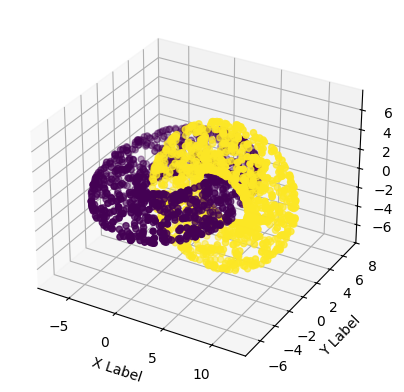

In [18]:
# Plotting
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z,c= bftc_label, marker='o', cmap='viridis')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()